## 전처리

각 '설문 문항 설명'을 '프로그램 종류'를 통해 카테고리화 했음.

'설문 문항 설명' 자체를 잠재요인 협업 필터링 해볼 것 => 자세하게 추천해줌
'프로그램 종류'로 잠재요인 협업 필터링 해볼 것 => 카테고리를 추천하여 그 속에 프로그램을 자유롭게 선택할 수 있음

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('./만족도.csv', encoding = 'cp949')
df1 = pd.read_csv('./프로그램카테고리.csv', encoding = 'cp949')

In [ ]:
df

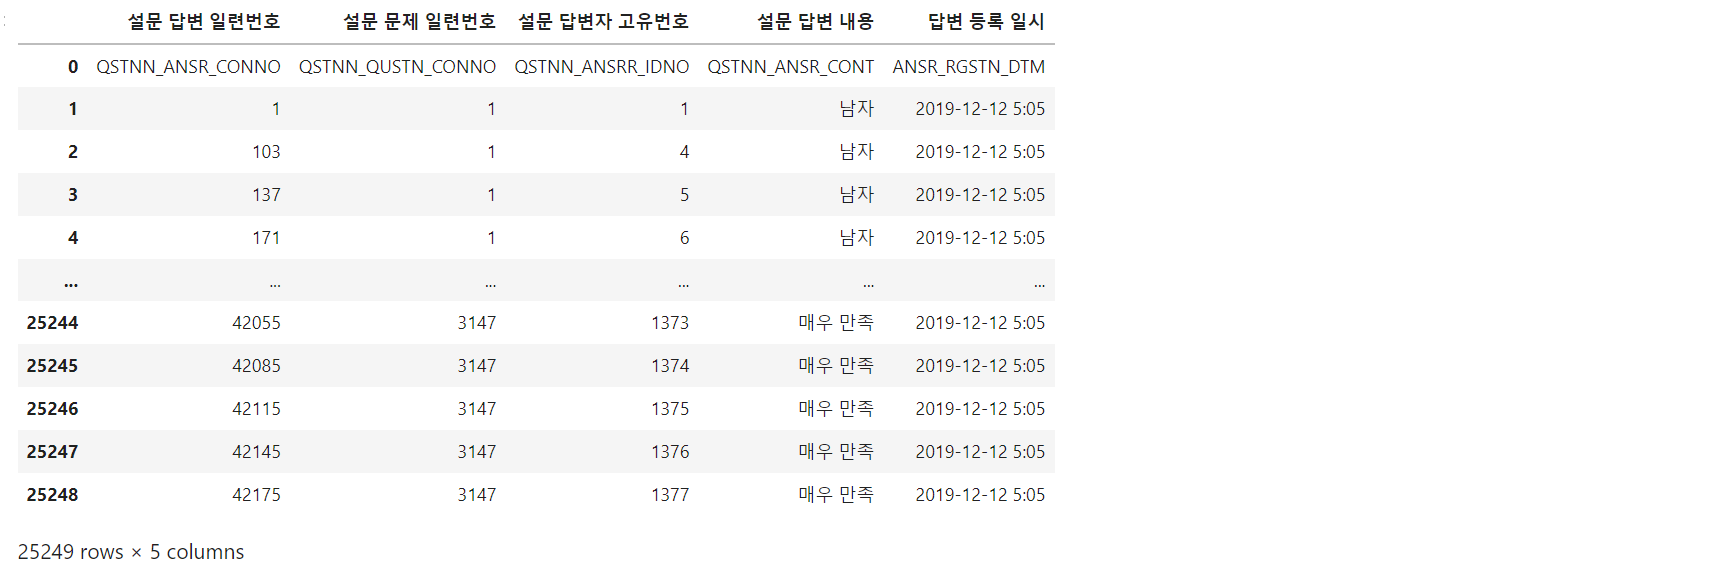

In [ ]:
df1

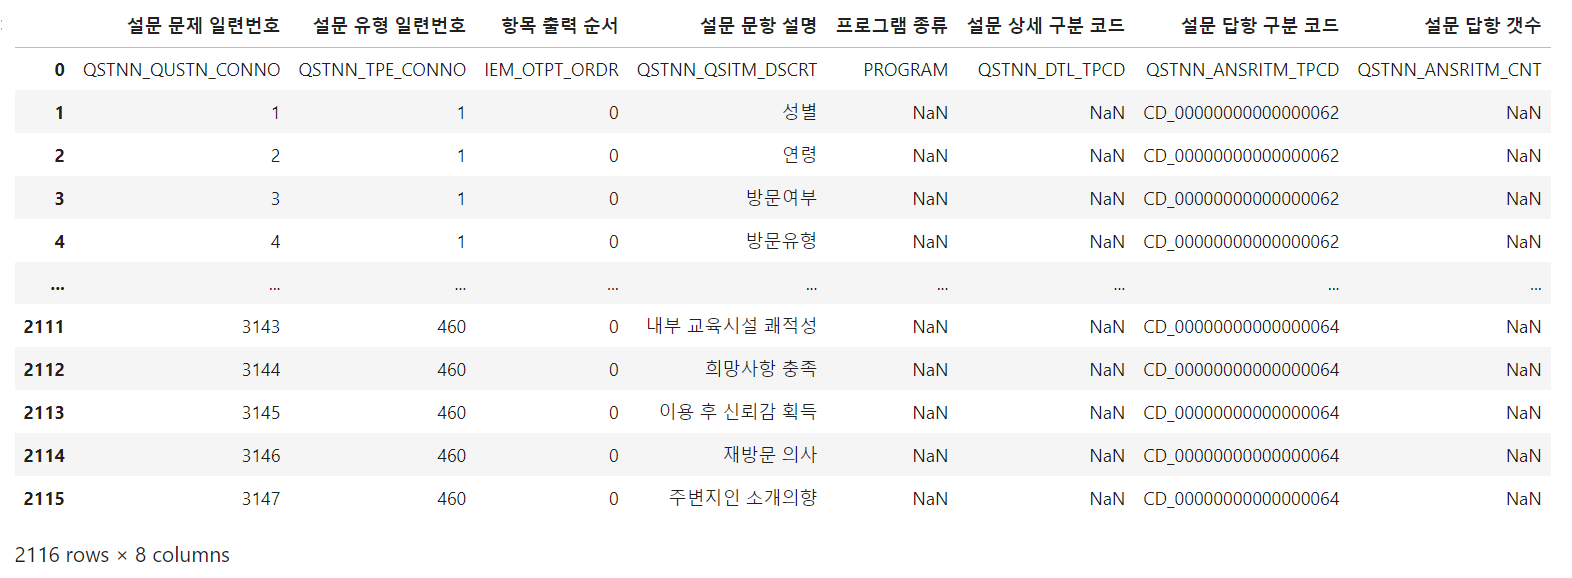

In [ ]:
new_df1 = df[df['설문 답변 내용'] == '매우 만족']
new_df2 = df[df['설문 답변 내용'] == '만족']
new_df3 = df[df['설문 답변 내용'] == '보통']

In [ ]:
new_df = pd.concat([new_df1, new_df2, new_df3])

In [ ]:
new_df = new_df.drop(['설문 답변 일련번호', '답변 등록 일시'], axis = 1)

In [ ]:
df1 = df1.drop(['설문 유형 일련번호', '항목 출력 순서', '설문 상세 구분 코드', '설문 답항 구분 코드','설문 답항 갯수'], axis = 1)
df1 = df1.dropna(axis = 0)
df1 = df1.drop(0)

In [ ]:
result = pd.merge(df1, new_df,how ='inner', on = '설문 문제 일련번호')

In [ ]:
result

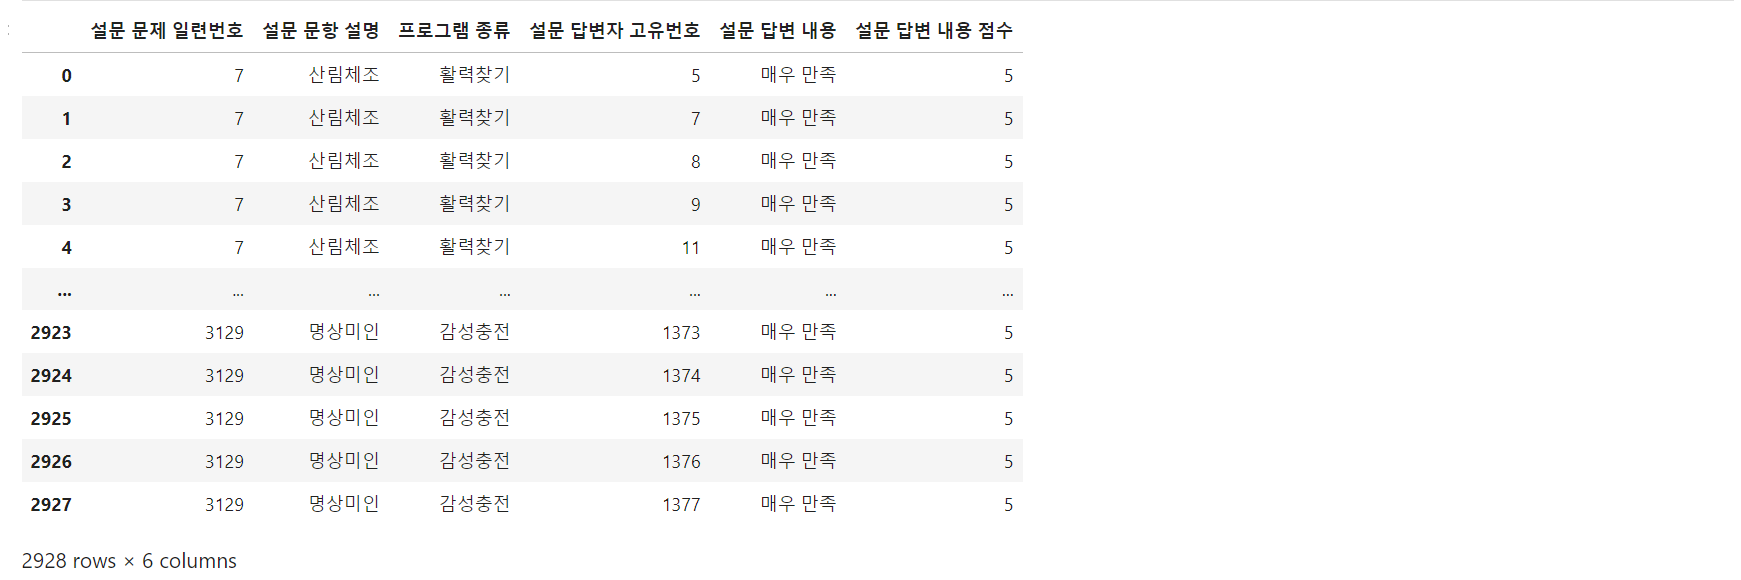

In [ ]:
result['설문 답변 내용 점수'] = 0

In [ ]:
for i in range(len(result['설문 답변 내용'])):
    if result['설문 답변 내용'][i] == '매우 만족':
        result['설문 답변 내용 점수'][i] = 5
    elif result['설문 답변 내용'][i] == '만족':
        result['설문 답변 내용 점수'][i] = 4
    elif result['설문 답변 내용'][i] == '보통':
        result['설문 답변 내용 점수'][i] = 3  

In [ ]:
result['설문 답변 내용 점수'].value_counts()

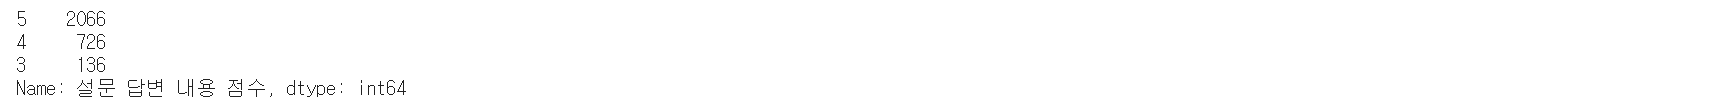

In [ ]:
result

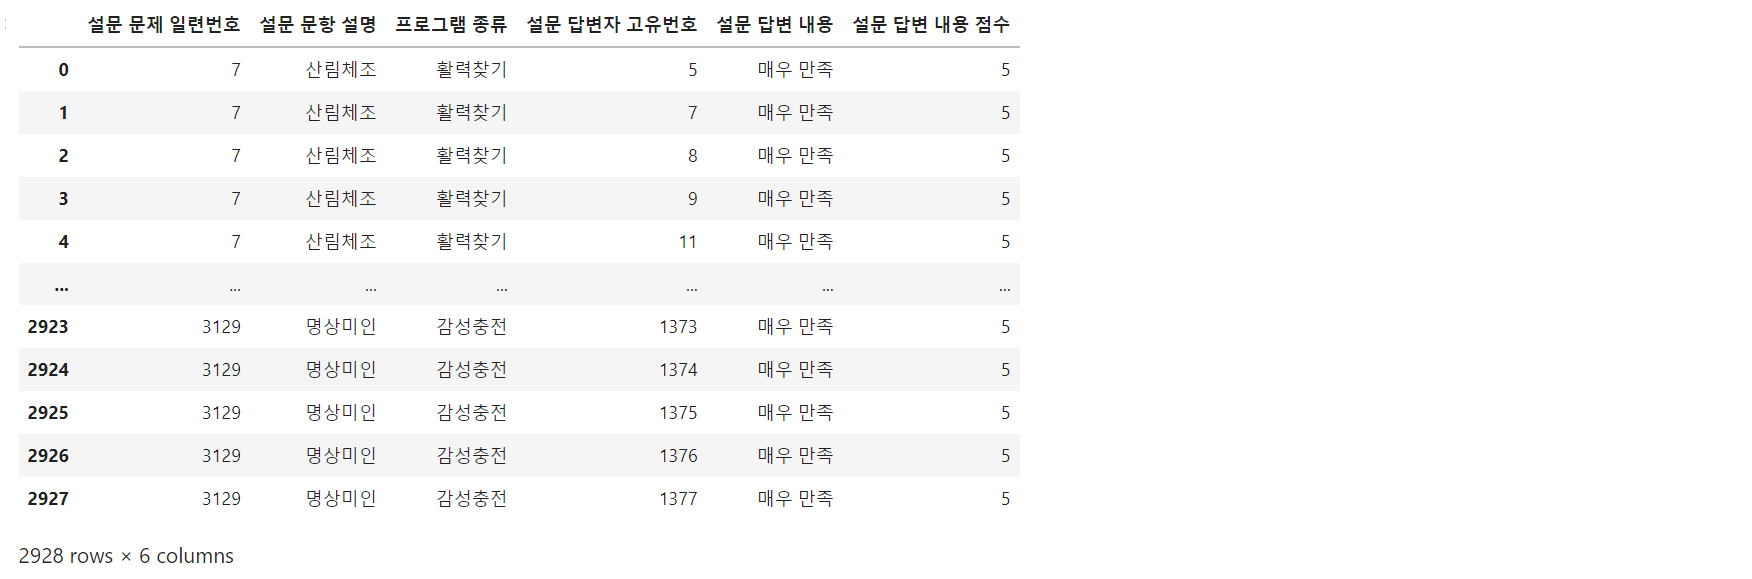

잠재요인 협업 필터링 진행시 필요한 함수

In [ ]:
from sklearn.metrics import mean_squared_error
# mse구해서 rsme구하는 함수
def get_rmse(R, P, Q, non_zeros):
    error = 0
    full_pred_matrix = np.dot(P, Q.T)
    
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)
    return rmse

In [1]:
# rmse를 이용하여 학습시키는 함수
def matrix_factorization(R, K, steps = 200, learning_rate = 0.01, r_lambda = 0.01):
    num_users, num_items = R.shape
    np.random.seed(1)
    P = np.random.normal(scale = 1./K, size = (num_users, K))
    Q = np.random.normal(scale = 1./K, size = (num_items, K))
    
    prev_rmse = 10000
    break_count = 0
    
    non_zeros = [(i, j , R[i, j])for i in range(num_users) for j in range(num_items) if R[i, j] > 0]
    
    for step in range(steps):
        for i, j, r in non_zeros:
            eij = r - np.dot(P[i,:], Q[j,:].T)
            P[i, :] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda * P[i,:])
            Q[j, :] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda * Q[j,:])
        rmse = get_rmse(R, P, Q, non_zeros)
        if (step % 10) == 0:
            print("###iteration step: ", step," rmse: ", rmse)
            
    return P, Q

In [2]:
# 참여하지 않은 활동을 골라내는 함수
def get_undo_activities(ratings_matrix, userId):
    user_rating = ratings_matrix.loc[userId, :]
    already_done = user_rating[user_rating > 0].index.tolist()
    activities_list = ratings_matrix.columns.tolist()
    
    undo_list = [activity for activity in activities_list if activity not in already_done]
    return undo_list

In [ ]:
# 참여하지 않은 활동을 골라낸 함수를 이용해 활동을 추천해 주는 함수
def recomm_activity_by_userid(pred_df, userId, undo_list, top_n = 10):
    recomm_activities = pred_df.loc[userId, undo_list].sort_values(ascending = False)[:top_n]
    return recomm_activities

설문 문항 설명을 이용한 잠재요인 협업 필터링

In [ ]:
result_pivot2 = pd.pivot_table(result, index = '설문 답변자 고유번호', values = '설문 답변 내용 점수', columns = '설문 문항 설명')#, fill_value = 0)
result_pivot2

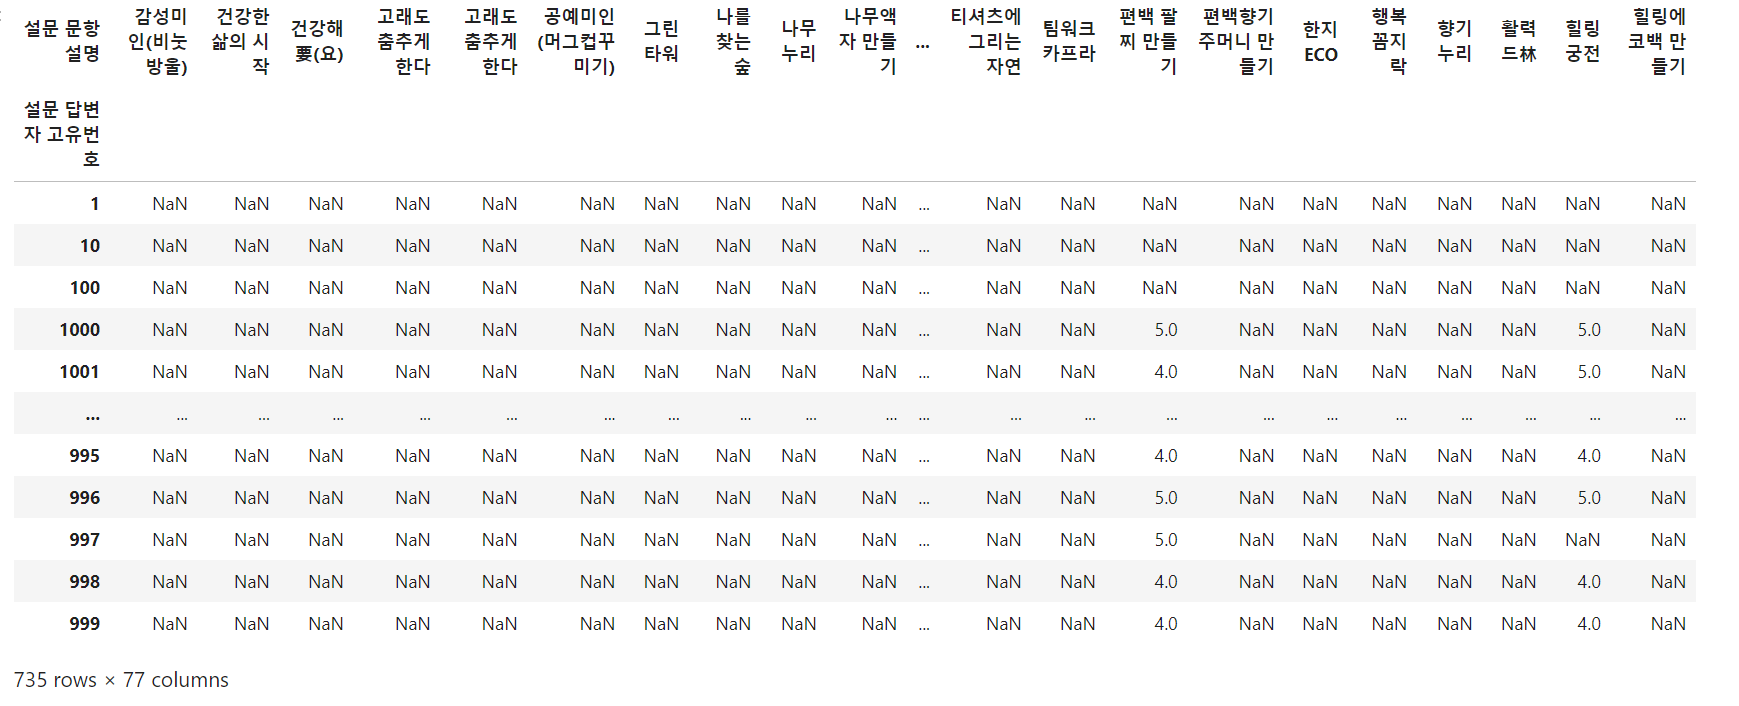

In [ ]:
# 학습
P, Q = matrix_factorization(result_pivot2.values, K= 50, steps = 200, learning_rate = 0.01, r_lambda = 0.01)

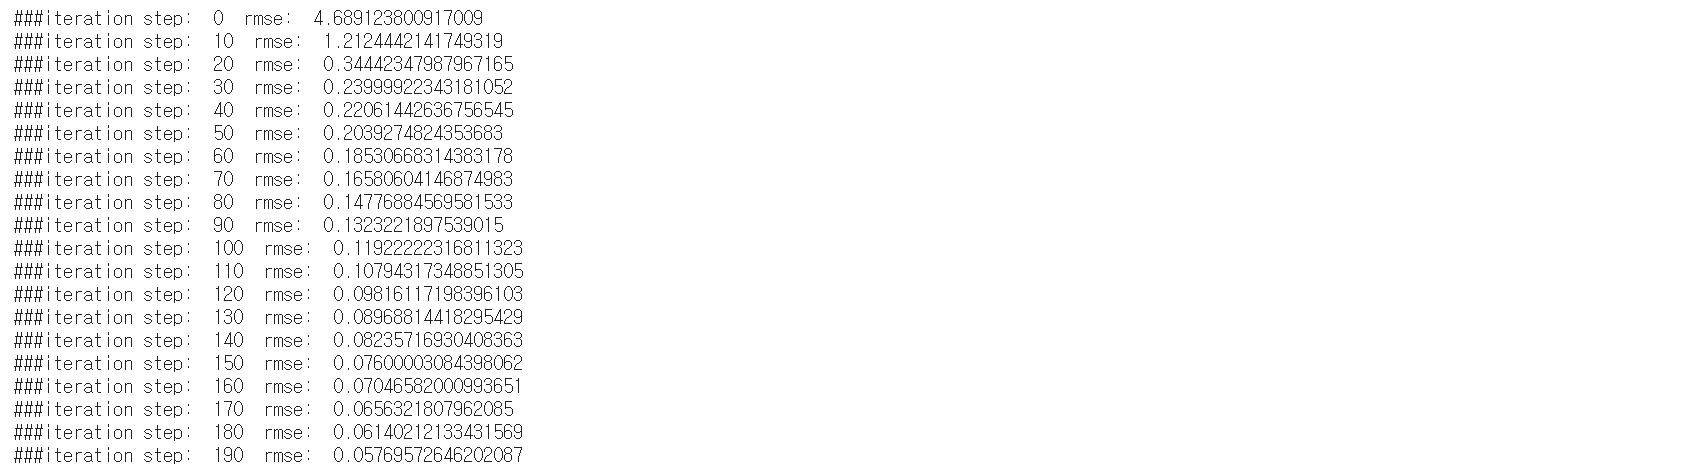

In [ ]:
pred_matrix = np.dot(P, Q.T)

In [ ]:
# dataframe으로 만들기
last = pd.DataFrame(data = pred_matrix, index = result_pivot2.index, columns = result_pivot2.columns)

In [ ]:
# userId 100인 사람에게 추천해주기
undo_list = get_undo_activities(result_pivot2, '100')
recomm_activities = recomm_activity_by_userid(last, '100', undo_list, top_n = 10)
recomm_activities = pd.DataFrame(data = recomm_activities.values, index = recomm_activities.index, columns = ['pred_score'])
recomm_activities

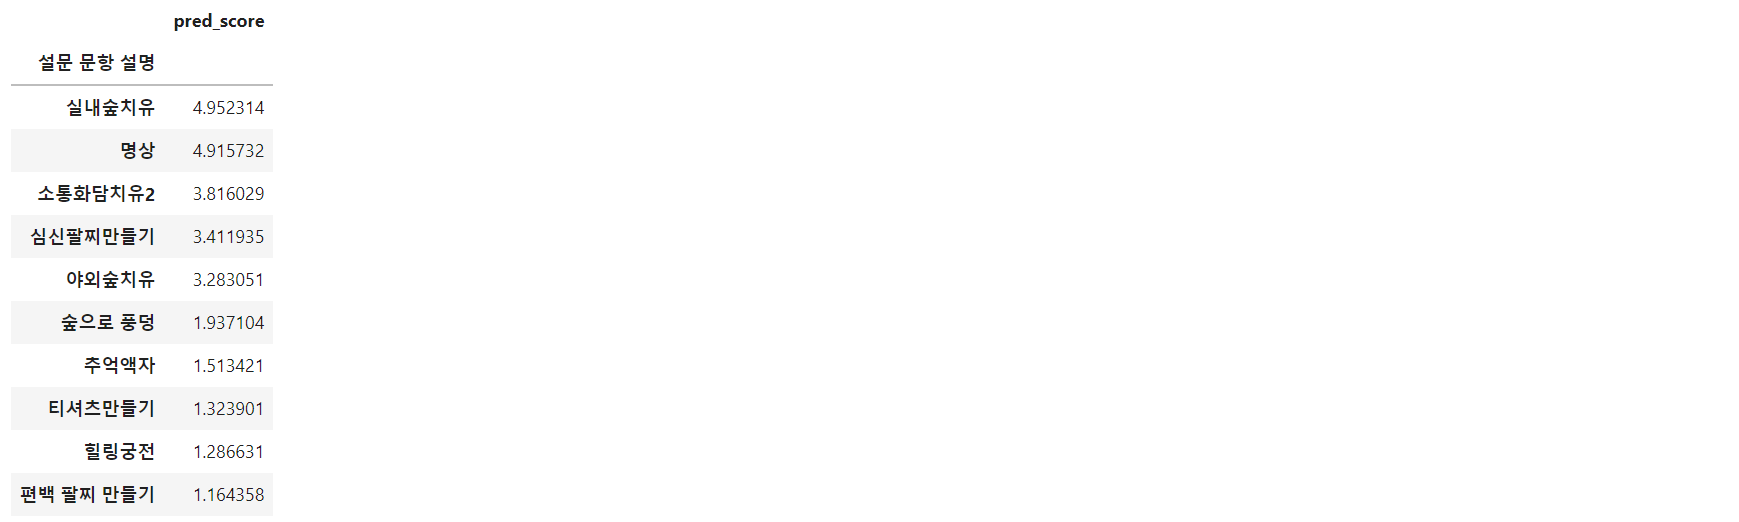

프로그램 종류를 이용한 잠재요인 협업 필터링

In [ ]:
result_pivot = pd.pivot_table(result, index= '설문 답변자 고유번호', values = '설문 답변 내용 점수', columns = '프로그램 종류')#,fill_value = 0)
result_pivot

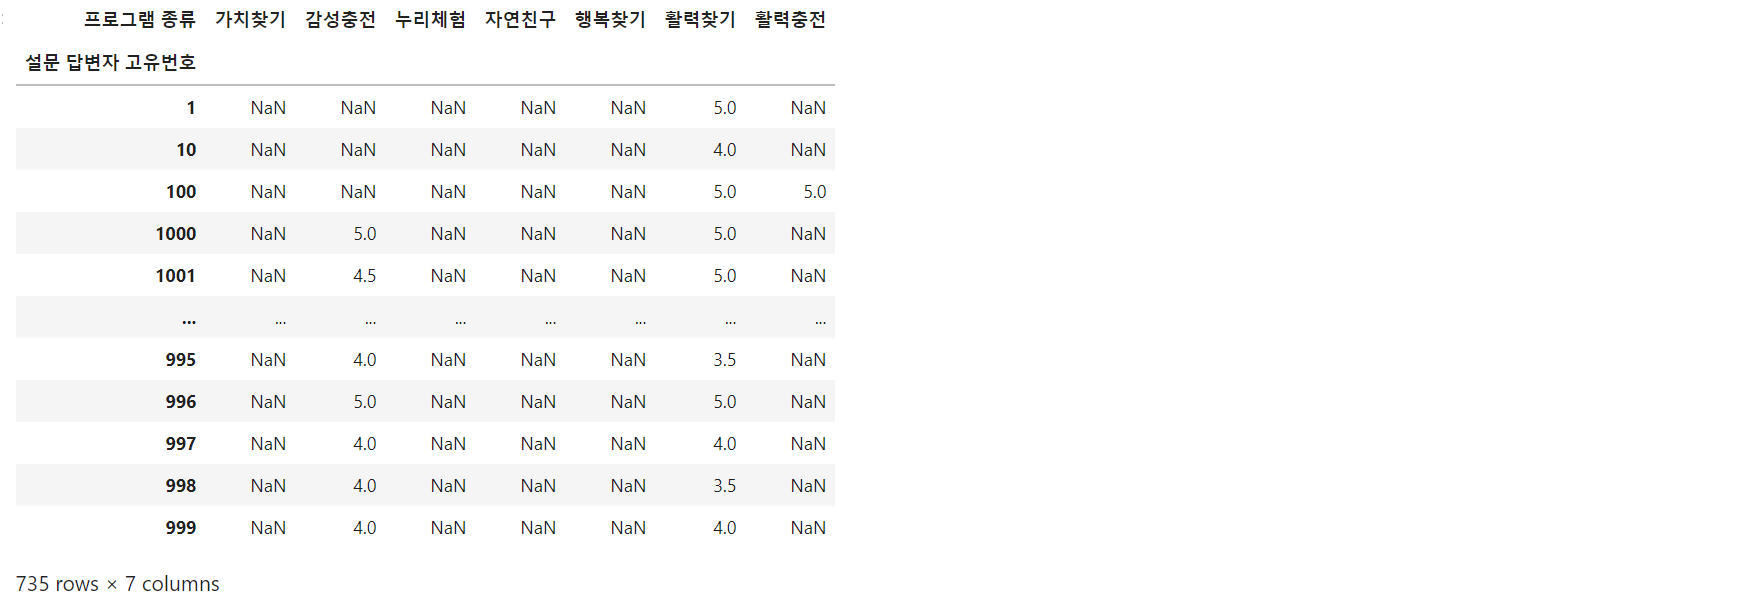

In [ ]:
P, Q = matrix_factorization(result_pivot.values, K= 50, steps = 200, learning_rate = 0.01, r_lambda = 0.01)

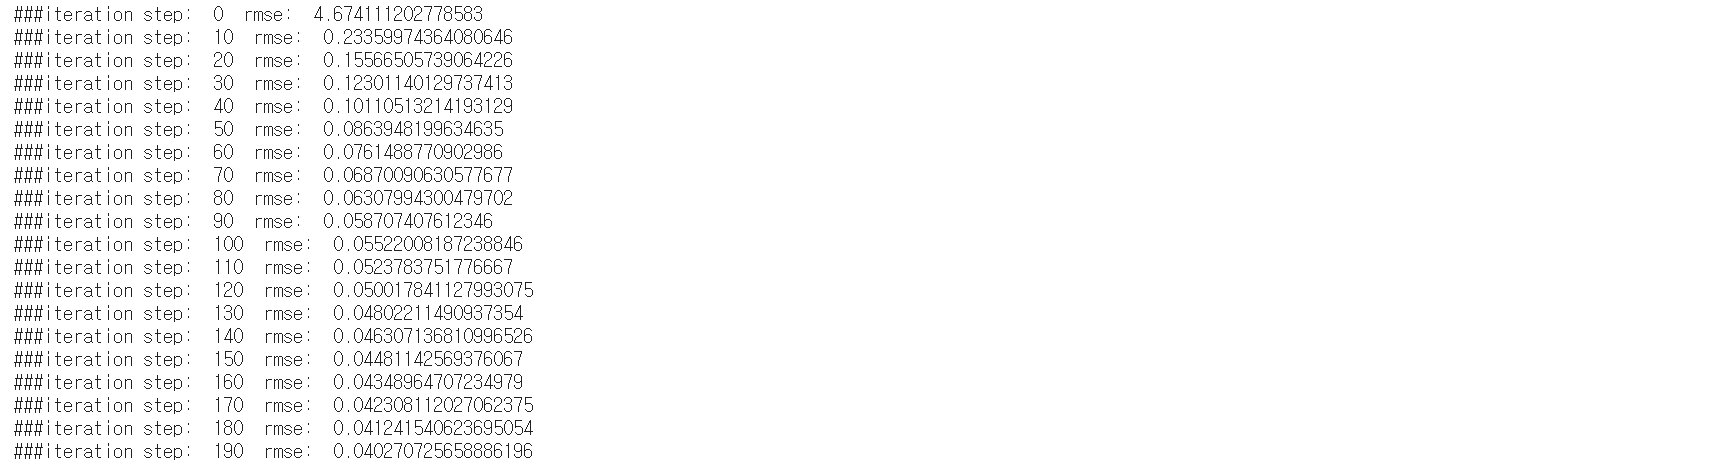

In [ ]:
pred_matrix = np.dot(P, Q.T)

In [ ]:
last = pd.DataFrame(data = pred_matrix, index = result_pivot.index, columns = result_pivot.columns)

In [ ]:
undo_list = get_undo_activities(result_pivot, '100')
recomm_activities = recomm_activity_by_userid(last, '100', undo_list, top_n = 10)
recomm_activities = pd.DataFrame(data = recomm_activities.values, index = recomm_activities.index, columns = ['pred_score'])
recomm_activities

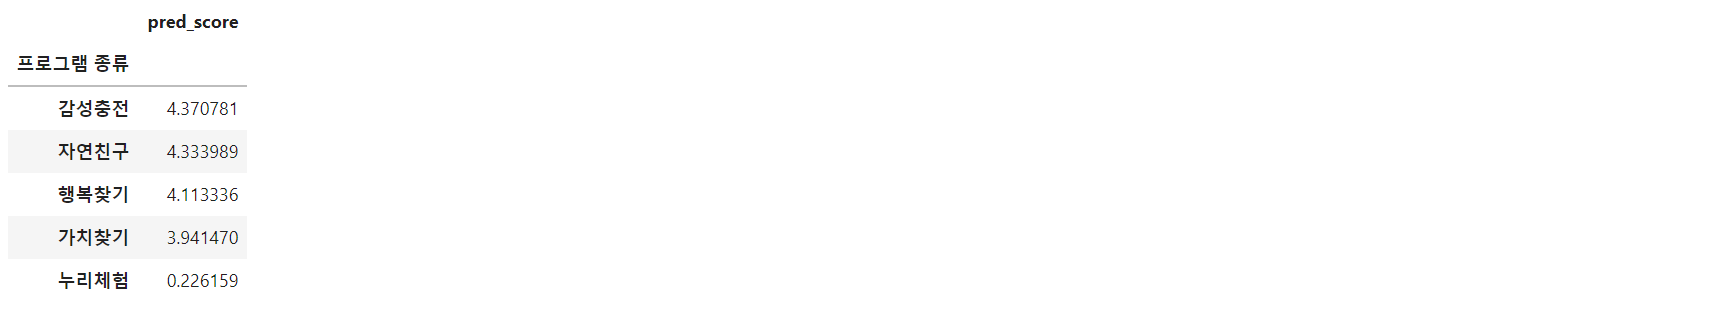